In [2]:
model = nn.Sequential(nn.Linear(10, 2), nn.Sigmoid())
model

Sequential(
  (0): Linear(in_features=10, out_features=2, bias=True)
  (1): Sigmoid()
)

In [4]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0958, -0.2342, -0.2400, -0.2560,  0.1258, -0.2339, -0.1426,  0.2288,
           0.2494, -0.1588],
         [-0.2239, -0.0848,  0.0590, -0.0673,  0.1967,  0.0627, -0.0977,  0.2734,
           0.0288, -0.1816]], requires_grad=True),
 Parameter containing:
 tensor([-0.3108, -0.2646], requires_grad=True)]

In [5]:
torch.save(model.state_dict(), 'test_model.pt')

In [3]:
model = nn.Module()
model.load_state_dict(torch.load('test_model.pt'))
model

RuntimeError: Error(s) in loading state_dict for Module:
	Unexpected key(s) in state_dict: "0.weight", "0.bias". 

In [9]:
df = pd.DataFrame(columns=['a', 'b'])
df.loc[1] = {'a':1, 'b':2}
df.empty

False

# Setting up Environment

In [1]:
# Data Science Tools
import numpy as np
import pandas as pd
import os

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import cuda, optim
from torch.utils.data import DataLoader, random_split

# Useful library for examining network
from torchsummary import summary

# Model, Datasets and transformations
import torchvision
import torchvision.transforms as T
from torchvision.datasets import FashionMNIST
from torchvision.models import vgg16, vgg19, vgg16_bn, vgg19_bn

# Timing utility
from timeit import default_timer as timer

# Log outputs
from TrainingLog import TrainingLog

In [30]:
# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Select Device
device = torch.device("cuda:0" if train_on_gpu else "cpu")

# Number of gpus
multi_gpu = False
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: False


# Preparing the Dataset

In [29]:
train_size, valid_size = 50000, 10000
random_seed = 0
torch.manual_seed(random_seed)

model_file_path = "Custom-VGG16-FashionMNIST.pt"
checkpoint_file = "checkpoint.tar"
learning_rate = 0.01

In [4]:
transform = T.Compose([
    T.Resize(size=224),
    T.Grayscale(num_output_channels=3),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

trainval_set = FashionMNIST(root='./data', download=True, transform=transform)
train_set, valid_set = random_split(trainval_set, [train_size, valid_size])
test_set = FashionMNIST(root='./data', train=False, transform=transform)
classes = {v:k for k,v in trainval_set.class_to_idx.items()}

In [5]:
batch_size = 100

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Exploring the Dataset

In [6]:
print("Training Data Size:", len(train_set))
print("Validation Data Size:", len(valid_set))
print("Test Data Size:", len(test_set))
print("Classes:")
classes

Training Data Size: 50000
Validation Data Size: 10000
Test Data Size: 10000
Classes:


{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

## Example from each category

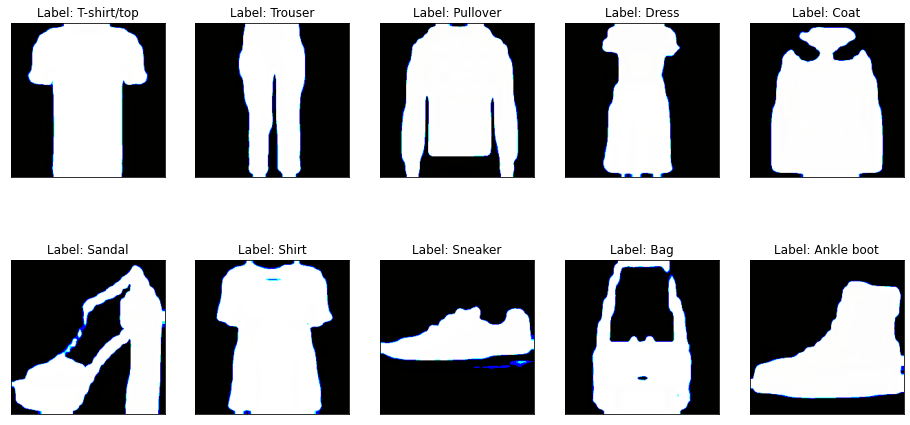

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# Take 1 example from each categoty
accuired_lebels = set()
subset = []
for data, lebel in train_set:
    if lebel not in accuired_lebels:
        subset.append((lebel, data))
        accuired_lebels.add(lebel)
        if len(accuired_lebels) == 10: break
subset.sort(key=lambda x: x[0])

plt.figure(figsize=(16, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(255 - subset[i][1].permute(1, 2, 0).numpy().astype('uint8'))
    plt.title("Label: {}".format(classes[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

# Building the Model

## Loading pretrained Model, Optimizer and Training History

In [24]:
# If Model is found in local directory
if os.path.exists(checkpoint_file):
    # Initialize Model and Optimizer
    model = nn.Module().to(device)
    optimizer = torch.optim.Optimizer()
    
    # Load Checkpoint
    if train_on_gpu:
        checkpoint = torch.load(checkpoint_file, map_location='cuda:0')
    else:
        checkpoint = torch.load(checkpoint_file)
    
    # Load Model, Optimizer, training_history
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.epochs = checkpoint['epochs']
    training_history = checkpoint['training_history']

# If the model is not found in local directory then download it
# And Define Optimizer and training history
else:
    # Download pretrained model
    model = vgg16(pretrained=True)
    
    # Keeping gradients for pretrained weights fixed
    for param in model.parameters():
        param.requires_grad = False
        
    # Adding custom layer for new number of outputs
    n_inputs = model.classifier[6].in_features
    model.classifier[6] = nn.Sequential(
        nn.Linear(n_inputs, 256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(256, len(classes)),
        nn.Softmax(dim=1)
    )
    
    # Set 'epochs' attribute in model to keep track of of epochs trained
    model.epochs = 0
    
    # Define Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Define DataFrame to keep track of training and
    # Validation loss and accuracy
    training_history = pd.DataFrame( 
        columns=[
            'train_loss', 'valid_loss', 
            'train_acc', 'valid_acc'
        ]
    )
    
    # Add Checkpoint
    torch.save({
        'epochs': model.epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'training_history': training_history        
    }, checkpoint_file)
    
# model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Calculating total and training parameters

In [25]:
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

135,311,946 total parameters.
1,051,402 training parameters.


## Moving the model to GPU if it is found



In [26]:
if train_on_gpu:
    model = model.to('cuda')

if multi_gpu:
    model = nn.DataParallel(model)

## Show Model Summary

In [27]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

# Training the Model

## Defining Loss Function

In [42]:
criterion = nn.CrossEntropyLoss()

## Defining Training Process

In [15]:
def train(model, criterion, optimizer, train_loader, valid_loader, checkpoint_file,
          save_file_name, training_history=None, max_epochs_stop=3, n_epochs=20, print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        checkpoint_file (str ending in '.tar'): file path to save checkpoint
        save_file_name (str ending in '.pt'): file path to save the model state dict
        training_history (Pandas DataFrame): A DataFrame for storing training and validation loss and accuracy
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        training_history (DataFrame): history of train and validation loss and accuracy
    """

    log = TrainingLog()
    
    # If early stopping is not chosen
    if max_epochs_stop == 0:
        max_epochs_stop = n_epochs

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    if not training_history:
        training_history = pd.DataFrame(
            columns=[
                'train_loss', 'valid_loss', 
                'train_acc', 'valid_acc'
            ]
        )
    else:
        print("Previous Training History:")
        print(training_history)

    # Number of epochs already trained (if using loaded in model weights)
    if not hasattr(model, 'epochs') or model.epochs == 0:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')
    else:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
        
    # try:
    #     print(f'Model has been trained for: {model.epochs} epochs.\n')
    # except:
    #     model.epochs = 0
    #     print(f'Starting Training from Scratch.\n')

    overall_start = timer()
    log.print_header()

    # Main loop
    for epoch in range(n_epochs):
        log.update_row(epoch_num=model.epochs + 1)

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0.0
        valid_acc = 0.0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            log.update_row(tp=(ii+1)/len(train_loader), tt=timer()-start)

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Calculate average train loss and accuracy
            train_loss = train_loss / len(train_loader.dataset)
            train_acc = train_acc / len(train_loader.dataset)

            # Print Training Result
            log.update_row(tl=train_loss, ta=train_acc)

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                start = timer()
                for jj, (data, target) in enumerate(valid_loader):
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
                    
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)
                    
                    # Track validation progress
                    log.update_row(vp=(jj+1)/len(valid_loader), vt=timer()-start)

                # Calculate average validation loss and accuracy
                valid_loss = valid_loss / len(valid_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                # Print Validation Result
                log.update_row(vl=valid_loss, va=valid_acc)

                # training_history.append([train_loss, valid_loss, train_acc, valid_acc])
                training_history.loc[model.epochs] = {
                    'train_loss': train_loss,
                    'valid_loss': valid_loss,
                    'train_acc' : train_acc,
                    'valid_acc' : valid_acc
                }

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save checkpoint
                    torch.save({
                        'epochs': model.epochs,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'training_history': training_history        
                    }, checkpoint_file)
                    # torch.save(model.state_dict(), save_file_name)
                    
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch + 1

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        log.finish()
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch + 1}. ' \
                            f'Best epoch: {best_epoch} with loss: {valid_loss_min:.4f} and acc: {valid_best_acc:.2%}'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch + 1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        if train_on_gpu:
                            checkpoint = torch.load(checkpoint_file, map_location='cuda:0')
                        else:
                            checkpoint = torch.load(checkpoint_file)    
                        model.load_state_dict(checkpoint['model_state_dict'])
                        
                        # Attach the optimizer
                        model.optimizer = optimizer
                        
                        # Update training_history in the checkpoint
                        checkpoint['training_history'] = training_history
                        
                        # Save updated checkpoint
                        torch.save(checkpoint, checkpoint_file)
                        
                        # Return Best Model and latest training_history
                        return model, training_history
        log.new_row()
    log.finish()
    
    # Load the best state dict
    if train_on_gpu:
        checkpoint = torch.load(checkpoint_file, map_location='cuda:0')
    else:
        checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Attach the optimizer
    model.optimizer = optimizer
    
    # Update training_history in the checkpoint
    checkpoint['training_history'] = training_history

    # Save updated checkpoint
    torch.save(checkpoint, checkpoint_file)
    
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {valid_best_acc:.2%}'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch + 1):.2f} seconds per epoch.'
    )
    
    return model, training_history

## Training

In [16]:
trained_model, training_history = train(model, criterion, optimizer,
                                        train_loade, valid_loader, checkpoint_file,
                                        model_file_path, training_history=training_history,
                                        max_epochs_stop=5, n_epochs=3)

Starting Training from Scratch.


|       |                 Training                 |                Validation                |
| Epoch |------------------------------------------|------------------------------------------|
|       |      Progress      |   Loss   | Accuracy |      Progress      |   Loss   | Accuracy |
|-------|--------------------|----------|----------|--------------------|----------|----------|
|   1   | 100.00% (274.13s)  |  1.7148  |  75.27%  |  100.00% (57.88s)  |  1.6400  |  82.16%  |
|   2   | 100.00% (259.74s)  |  1.6616  |  80.06%  |  100.00% (52.41s)  |  1.6364  |  82.28%  |
|   3   | 100.00% (258.12s)  |  1.6570  |  80.40%  |  100.00% (52.03s)  |  1.6260  |  83.53%  |
|   4   | 100.00% (257.54s)  |  1.6508  |  80.99%  |  100.00% (52.69s)  |  1.6224  |  84.01%  |
|   5   | 100.00% (257.02s)  |  1.6487  |  81.22%  |  100.00% (52.55s)  |  1.6159  |  84.49%  |
|   6   | 100.00% (258.25s)  |  1.6451  |  81.62%  |  100.00% (52.50s)  |  1.6205  |  83.97%  |
|   7 

In [17]:
def evaluate(model, criterion, data_loader):
    total_loss = 0
    total_acc = 0

    for data, target in data_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Forward Pass
        output = model(data)

        # Loss
        loss = criterion(output, target)
        # Multiply average loss times the number of examples in batch
        total_loss += loss.item() * data.size(0)

        # Calculate accuracy
        _, pred = torch.max(output, dim=1)
        correct_tensor = pred.eq(target.data.view_as(pred))
        accuracy = torch.mean(
            correct_tensor.type(torch.FloatTensor))
        # Multiply average accuracy times the number of examples
        total_acc += accuracy.item() * data.size(0)

    total_loss = total_loss / len(data_loader.dataset)
    total_acc = total_acc / len(data_loader.dataset)

    return total_loss, total_acc


In [18]:
avg_loss, accuracy = evaluate(trained_model, criterion, test_loader)
print("Average Test Loss: {:.4F}\nTest Accuracy: {:.2%}".format(avg_loss, accuracy))

Average Test Loss: 1.6105
Test Accuracy: 85.01%


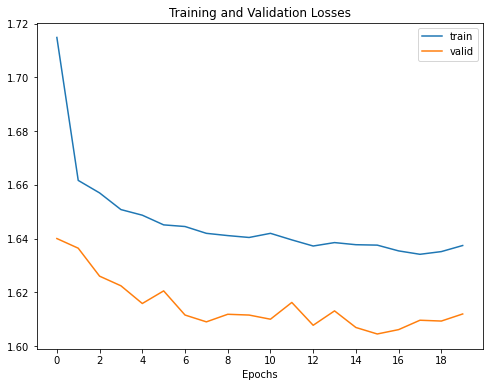

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(training_history['train_loss'], label='train')
plt.plot(training_history['valid_loss'], label='valid')
plt.legend()
plt.title("Training and Validation Losses")
plt.xticks(np.arange(20, step=2))
plt.xlabel("Epochs")
plt.show()

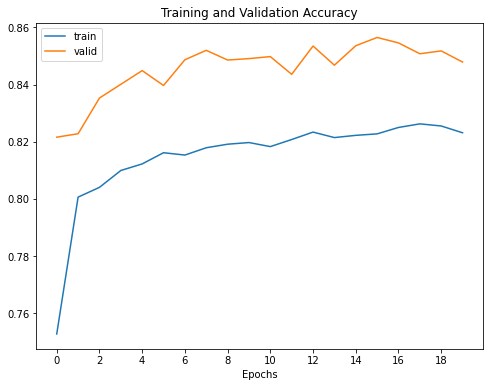

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(training_history['train_acc'], label='train')
plt.plot(training_history['valid_acc'], label='valid')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.xticks(np.arange(20, step=2))
plt.xlabel("Epochs")
plt.show()

In [45]:
torch.load(model_file)

OrderedDict([('features.0.weight',
              tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
                        [-5.8312e-01,  3.5655e-01,  7.6566e-01],
                        [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
              
                       [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
                        [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
                        [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
              
                       [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
                        [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
                        [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
              
              
                      [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
                        [-4.2805e-01, -2.4349e-01,  2.4628e-01],
                        [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
              
                       [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
                        [-8.4127e-01, -3